# 查看FashionMNIST原始数据格式

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from wangdao_deeplearning_train import EarlyStopping, ModelSaver,train_classification_model,plot_learning_curves
from wangdao_deeplearning_train import evaluate_classification_model


In [2]:
import torch.nn as nn
import matplotlib.pyplot as plt

# 创建一个随机输入张量，模拟特征图
# 形状为 [1, 3, 6, 6]，表示1个样本，3个通道，6x6的特征图
input_tensor = torch.randn(1, 3, 6, 6)
print("输入张量的形状:", input_tensor.shape)

# 创建 AdaptiveAvgPool2d 层，指定输出大小为 2x2
adaptive_pool = nn.AdaptiveAvgPool2d(output_size=(2, 2))

# 对输入张量进行自适应平均池化
output_tensor = adaptive_pool(input_tensor)
print("输出张量的形状:", output_tensor.shape)



输入张量的形状: torch.Size([1, 3, 6, 6])
输出张量的形状: torch.Size([1, 3, 2, 2])


In [3]:
import json
token = {"username":"huangdongsheng123","key":"bc7074d3e7a23aa7233f350712ff381d"}
with open('/content/kaggle.json', 'w') as file:
  json.dump(token, file)

In [4]:
!cat /content/kaggle.json

{"username": "huangdongsheng123", "key": "bc7074d3e7a23aa7233f350712ff381d"}

In [5]:
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content

- path is now set to: /content


In [6]:
!kaggle competitions download -c cifar-10

cifar-10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
replace sampleSubmission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [9]:
%pip install py7zr
import py7zr
a =py7zr.SevenZipFile(r'./train.7z','r')
a.extractall(path=r'./competitions/cifar-10/')
a.close()

In [10]:
!ls competitions/cifar-10/train|wc -l

50000


# 加载数据并处理为tensor

In [11]:
# 加载CIFAR-10数据集
import os
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset

# 定义CIFAR-10数据集类
class CIFAR10Dataset(Dataset):
    def __init__(self, img_dir, labels_file, transform=None):
        self.img_dir = img_dir
        self.transform = transform

        # 读取标签文件，read_csv默认读取第一行作为列名
        self.labels_df = pd.read_csv(labels_file)
        self.img_names = self.labels_df.iloc[:, 0].values.astype(str)  # 第一列是图片名称，确保为字符串类型

        # 类别名称字典，使用字典可以提高查找速度
        self.class_names_dict = {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3,
                                 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
        # 将文本标签转换为数字ID
        self.labels = [self.class_names_dict[label] for label in self.labels_df.iloc[:, 1].values]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx] + '.png') #图片路径
        image = Image.open(img_path) #打开图片
        label = self.labels[idx]

        if self.transform:
            image_tensor = self.transform(image)

        return image_tensor, label

# 定义数据预处理
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4917, 0.4823, 0.4467), (0.2024, 0.1995, 0.2010))
])

# colab加载CIFAR-10数据集
img_dir = r"competitions/cifar-10/train"
labels_file = r"./trainLabels.csv"

# img_dir = r"D:\cifar-10\train\train"
# labels_file = r"D:\cifar-10\trainLabels.csv"
full_dataset = CIFAR10Dataset(img_dir=img_dir, labels_file=labels_file, transform=transform)

# 定义类别名称
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 划分训练集和验证集
train_size = 45000
val_size = 5000
generator = torch.Generator().manual_seed(42)
train_dataset, val_dataset = torch.utils.data.random_split(
    full_dataset,
    [train_size, val_size],
    generator=generator
)

# 查看数据集基本信息
print(f"完整数据集大小: {len(full_dataset)}")
print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")


完整数据集大小: 50000
训练集大小: 45000
验证集大小: 5000


In [12]:
def cal_mean_std(ds):
    mean = 0.
    std = 0.
    for img, _ in ds:
        mean += img.mean(dim=(1, 2)) #dim=(1, 2)表示在通道维度上求平均
        std += img.std(dim=(1, 2))  #dim=(1, 2)表示在通道维度上求标准差
    mean /= len(ds)
    std /= len(ds)
    return mean, std
# cal_mean_std(train_dataset)

# 把数据集划分为训练集45000和验证集5000，并给DataLoader

In [13]:

# 创建数据加载器
batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True #打乱数据集，每次迭代时，数据集的顺序都会被打乱
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False
)




# 搭建模型

In [14]:
#理解每个接口的方法，单独写例子
import torch.nn as nn
m=nn.BatchNorm1d(100)
x=torch.randn(20,100)
print(m(x).shape)

torch.Size([20, 100])


# 复现VGG11简单版

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class VGG11(nn.Module):
    def __init__(self):
        super().__init__()

        # VGG11架构的卷积层配置
        # 第一个卷积块 - 1个卷积层
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第二个卷积块 - 1个卷积层
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第三个卷积块 - 2个卷积层
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第四个卷积块 - 2个卷积层
        self.conv_block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 第五个卷积块 - 2个卷积层
        self.conv_block5 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # 全连接层 - 适配CIFAR-10的10个类别
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 10)  # 10分类
        )

        # 初始化权重
        self.init_weights()

    def init_weights(self):
        """使用xavier均匀分布初始化权重"""
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
    @classmethod
    def from_pretrained(cls, weights_path):
        """
        从预训练权重加载模型，并弹出分类层权重

        参数:
            weights_path: 预训练权重文件路径

        返回:
            加载了预训练权重的模型实例
        """
        # 创建模型实例
        model = cls()

        # 加载预训练权重
        pretrained_weights = torch.load(weights_path)

        # 创建新的权重字典，排除分类器的最后一层
        model_dict = model.state_dict()
        pretrained_dict = {k: v for k, v in pretrained_weights.items()
                          if k in model_dict and 'classifier.6' not in k}

        # 更新模型权重
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)

        print(f"成功加载预训练权重，排除了分类器的最后一层")

        return model
    def forward(self, x):
        # 卷积块前向传播
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)
        x = self.conv_block4(x)
        x = self.conv_block5(x)

        # 展平操作 - CIFAR-10经过5次下采样后为1x1
        x = x.view(x.size(0), -1)

        # 分类器
        x = self.classifier(x)

        return x


In [16]:
# 实例化模型
model = VGG11()

# 从train_loader获取第一个批次的数据
dataiter = iter(train_loader)
images, labels = next(dataiter)

# 查看批次数据的形状
print("批次图像形状:", images.shape)
print("批次标签形状:", labels.shape)

# 输出模型每一层的名字
print('-'*100)
print("模型各层名称:")
for name, module in model.named_modules():
    if name != '':  # 跳过顶层模型本身
        print(f"- {name}")

print('-'*100)
# 进行前向传播
with torch.no_grad():  # 不需要计算梯度
    outputs = model(images)

print(outputs.shape)


批次图像形状: torch.Size([64, 3, 32, 32])
批次标签形状: torch.Size([64])
----------------------------------------------------------------------------------------------------
模型各层名称:
- conv_block1
- conv_block1.0
- conv_block1.1
- conv_block1.2
- conv_block1.3
- conv_block2
- conv_block2.0
- conv_block2.1
- conv_block2.2
- conv_block2.3
- conv_block3
- conv_block3.0
- conv_block3.1
- conv_block3.2
- conv_block3.3
- conv_block3.4
- conv_block3.5
- conv_block3.6
- conv_block4
- conv_block4.0
- conv_block4.1
- conv_block4.2
- conv_block4.3
- conv_block4.4
- conv_block4.5
- conv_block4.6
- conv_block5
- conv_block5.0
- conv_block5.1
- conv_block5.2
- conv_block5.3
- conv_block5.4
- conv_block5.5
- conv_block5.6
- classifier
- classifier.0
- classifier.1
- classifier.2
- classifier.3
- classifier.4
- classifier.5
- classifier.6
----------------------------------------------------------------------------------------------------
torch.Size([64, 10])


In [17]:
# 计算模型的总参数量
# 统计需要求梯度的参数总量
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"需要求梯度的参数总量: {total_params}")

# 统计所有参数总量
all_params = sum(p.numel() for p in model.parameters())
print(f"模型总参数量: {all_params}")

# 查看每层参数量明细
print("\n各层参数量明细:")
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} 参数")


需要求梯度的参数总量: 15532810
模型总参数量: 15532810

各层参数量明细:
conv_block1.0.weight: 1728 参数
conv_block1.0.bias: 64 参数
conv_block1.1.weight: 64 参数
conv_block1.1.bias: 64 参数
conv_block2.0.weight: 73728 参数
conv_block2.0.bias: 128 参数
conv_block2.1.weight: 128 参数
conv_block2.1.bias: 128 参数
conv_block3.0.weight: 294912 参数
conv_block3.0.bias: 256 参数
conv_block3.1.weight: 256 参数
conv_block3.1.bias: 256 参数
conv_block3.3.weight: 589824 参数
conv_block3.3.bias: 256 参数
conv_block3.4.weight: 256 参数
conv_block3.4.bias: 256 参数
conv_block4.0.weight: 1179648 参数
conv_block4.0.bias: 512 参数
conv_block4.1.weight: 512 参数
conv_block4.1.bias: 512 参数
conv_block4.3.weight: 2359296 参数
conv_block4.3.bias: 512 参数
conv_block4.4.weight: 512 参数
conv_block4.4.bias: 512 参数
conv_block5.0.weight: 2359296 参数
conv_block5.0.bias: 512 参数
conv_block5.1.weight: 512 参数
conv_block5.1.bias: 512 参数
conv_block5.3.weight: 2359296 参数
conv_block5.3.bias: 512 参数
conv_block5.4.weight: 512 参数
conv_block5.4.bias: 512 参数
classifier.0.weight: 2097152 参数
cl

In [19]:
model.state_dict()

OrderedDict([('conv_block1.0.weight',
              tensor([[[[-0.0743,  0.0052, -0.0538],
                        [-0.0878,  0.0547,  0.0698],
                        [-0.0239,  0.0398,  0.0381]],
              
                       [[-0.0088,  0.0380, -0.0149],
                        [-0.0175, -0.0843,  0.0390],
                        [ 0.0747, -0.0278, -0.0794]],
              
                       [[ 0.0627, -0.0535,  0.0962],
                        [ 0.0345, -0.0663, -0.0171],
                        [ 0.0220, -0.0907, -0.0126]]],
              
              
                      [[[-0.0193, -0.0644,  0.0709],
                        [ 0.0656, -0.0919,  0.0237],
                        [ 0.0251, -0.0558, -0.0683]],
              
                       [[ 0.0734, -0.0380, -0.0206],
                        [-0.0339,  0.0966, -0.0859],
                        [-0.0651,  0.0091, -0.0344]],
              
                       [[ 0.0980, -0.0094,  0.0273],
                  

# 设置交叉熵损失函数，SGD优化器

In [20]:
model = VGG11()
# 定义损失函数和优化器
loss_fn = nn.CrossEntropyLoss()  # 交叉熵损失函数，适用于多分类问题，里边会做softmax，还有会把0-9标签转换成one-hot编码

print("损失函数:", loss_fn)



损失函数: CrossEntropyLoss()


In [21]:
model = VGG11()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # SGD优化器，学习率为0.01，动量为0.9

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用设备: {device}")
model = model.to(device) #将模型移动到GPU
early_stopping=EarlyStopping(patience=5, delta=0.001)
model_saver=ModelSaver(save_dir='model_weights', save_best_only=True)


model, history = train_classification_model(model, train_loader, val_loader, loss_fn, optimizer, device, num_epochs=50, early_stopping=early_stopping, model_saver=model_saver, tensorboard_logger=None)



使用设备: cuda:0
训练开始，共35200步


  0%|          | 0/35200 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 83.1600
早停: 在14500 步


In [23]:
history['train'][-100:-1]

[{'loss': 0.023312576115131378, 'acc': 100.0, 'step': 14401},
 {'loss': 0.009006999433040619, 'acc': 100.0, 'step': 14402},
 {'loss': 0.10521949082612991, 'acc': 95.3125, 'step': 14403},
 {'loss': 0.04676873981952667, 'acc': 98.4375, 'step': 14404},
 {'loss': 0.021992700174450874, 'acc': 100.0, 'step': 14405},
 {'loss': 0.0979493036866188, 'acc': 95.3125, 'step': 14406},
 {'loss': 0.01782625913619995, 'acc': 100.0, 'step': 14407},
 {'loss': 0.3161410689353943, 'acc': 95.3125, 'step': 14408},
 {'loss': 0.19845212996006012, 'acc': 98.4375, 'step': 14409},
 {'loss': 0.058203183114528656, 'acc': 96.875, 'step': 14410},
 {'loss': 0.07757660001516342, 'acc': 98.4375, 'step': 14411},
 {'loss': 0.10261082649230957, 'acc': 98.4375, 'step': 14412},
 {'loss': 0.1983618140220642, 'acc': 93.75, 'step': 14413},
 {'loss': 0.3938461244106293, 'acc': 92.1875, 'step': 14414},
 {'loss': 0.04293433576822281, 'acc': 96.875, 'step': 14415},
 {'loss': 0.14773964881896973, 'acc': 95.3125, 'step': 14416},
 {'l

In [24]:
history['val'][-100:-1]

[{'loss': 2.3032538063049315, 'acc': 9.76, 'step': 0},
 {'loss': 1.8053065771102905, 'acc': 29.0, 'step': 500},
 {'loss': 1.593047946357727, 'acc': 40.3, 'step': 1000},
 {'loss': 1.1724864854812622, 'acc': 58.96, 'step': 1500},
 {'loss': 0.987095175743103, 'acc': 65.14, 'step': 2000},
 {'loss': 0.9081858105659485, 'acc': 67.94, 'step': 2500},
 {'loss': 0.9122831447601318, 'acc': 70.34, 'step': 3000},
 {'loss': 0.7437661161661148, 'acc': 74.58, 'step': 3500},
 {'loss': 0.7081141306400299, 'acc': 76.12, 'step': 4000},
 {'loss': 0.752126741695404, 'acc': 76.28, 'step': 4500},
 {'loss': 0.6401531141757965, 'acc': 79.84, 'step': 5000},
 {'loss': 0.6282181456565857, 'acc': 78.78, 'step': 5500},
 {'loss': 0.6885673773527146, 'acc': 78.66, 'step': 6000},
 {'loss': 0.8621841143608093, 'acc': 75.86, 'step': 6500},
 {'loss': 0.5719097415447235, 'acc': 82.36, 'step': 7000},
 {'loss': 0.6072489501953126, 'acc': 82.4, 'step': 7500},
 {'loss': 0.7117374522209168, 'acc': 81.0, 'step': 8000},
 {'loss':

# 绘制损失曲线和准确率曲线

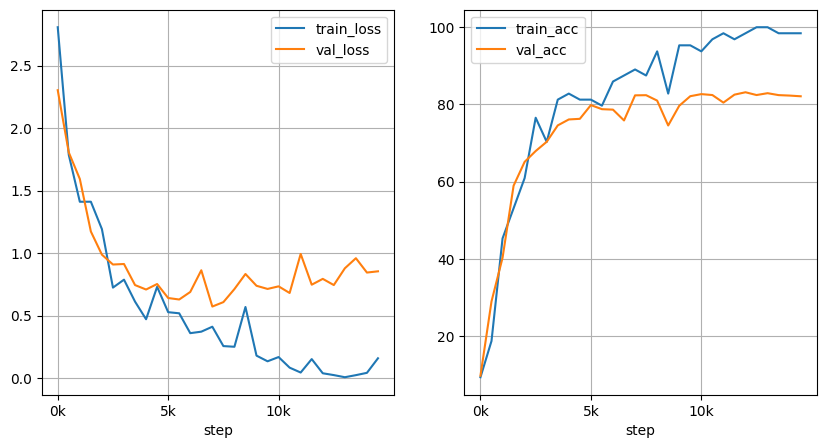

In [25]:
plot_learning_curves(history, sample_step=500)  #横坐标是 steps

In [26]:
# 加载最佳模型权重
best_model = VGG11()
best_model.to(device)

# 从保存的权重文件中加载模型
model_path = os.path.join('model_weights', 'model_epoch_82.12_acc_20.0000.pth')

best_model.load_state_dict(torch.load(model_path))
print(f"成功加载模型权重: {model_path}")


# 在验证集上评估模型
val_accuracy, val_loss = evaluate_classification_model(best_model, val_loader, device, loss_fn)
print(f"验证集准确率: {val_accuracy:.2f}%")
print(f"验证集损失: {val_loss:.4f}")


成功加载模型权重: model_weights/model_epoch_82.12_acc_20.0000.pth
验证集准确率: 82.12%
验证集损失: 0.8538


成功加载预训练权重，排除了分类器的最后一层
开始微调预训练的VGG11模型...
训练开始，共14080步


  0%|          | 0/14080 [00:00<?, ?it/s]

早停触发! 最佳验证准确率(如果是回归，这里是损失): 85.0000
早停: 在8000 步


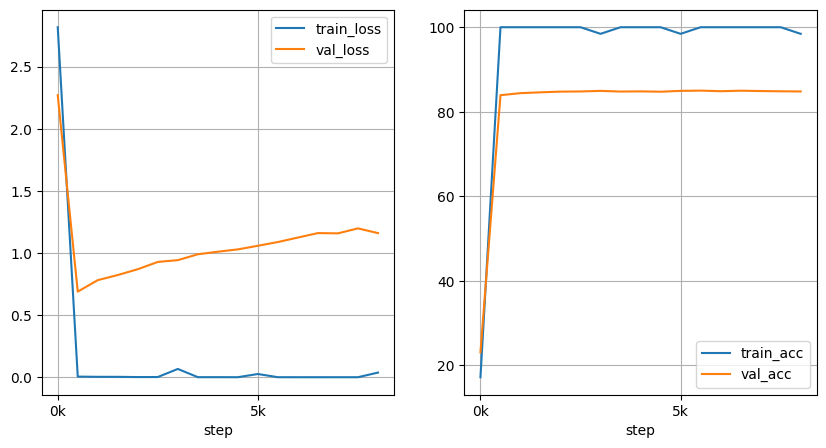

微调后模型在验证集上的准确率: 84.80%
微调后模型在验证集上的损失: 1.1598

性能比较:
原始模型验证集准确率: 82.12%
微调模型验证集准确率: 84.80%
准确率提升: 2.68%


In [27]:
# 定义一个函数来获取预训练的VGG11模型并设置不同层的学习率
def get_finetuned_model(num_classes=10):
    # 加载预训练的VGG11模型
    model = VGG11.from_pretrained(model_path)

    # 将模型移至设备
    model = model.to(device)

    # 为不同层设置不同的学习率
    # 冻结特征提取层参数或使用较小的学习率
    feature_params = []
    classifier_params = []

    # 将参数分为特征提取层和分类层
    for name, param in model.named_parameters():
        if 'classifier' in name:
            if '6' in name:  # 最后一层（新添加的分类层）
                classifier_params.append(param)
            else:  # 分类器的其他层
                feature_params.append(param)
        else:  # 特征提取层
            feature_params.append(param)

    # 创建优化器，对不同层使用不同的学习率
    optimizer = torch.optim.Adam([
        {'params': feature_params, 'lr': 1e-5},  # 特征提取层使用较小的学习率
        {'params': classifier_params, 'lr': 1e-3}  # 分类层使用较大的学习率
    ])

    return model, optimizer

# 获取微调模型和优化器
finetune_model, finetune_optimizer = get_finetuned_model()

# 训练微调模型
finetune_early_stopping = EarlyStopping(patience=5)
finetune_model_saver = ModelSaver(save_dir='finetune_model_weights', save_best_only=True)

print("开始微调预训练的VGG11模型...")
finetune_model, finetune_history = train_classification_model(
    finetune_model,
    train_loader,
    val_loader,
    loss_fn,
    finetune_optimizer,
    device,
    num_epochs=20,
    early_stopping=finetune_early_stopping,
    model_saver=finetune_model_saver
)

# 绘制微调模型的学习曲线
plot_learning_curves(finetune_history, sample_step=500)

# 评估微调后的模型
finetune_val_accuracy, finetune_val_loss = evaluate_classification_model(finetune_model, val_loader, device, loss_fn)
print(f"微调后模型在验证集上的准确率: {finetune_val_accuracy:.2f}%")
print(f"微调后模型在验证集上的损失: {finetune_val_loss:.4f}")

# 比较原始模型和微调模型的性能
print("\n性能比较:")
print(f"原始模型验证集准确率: {val_accuracy:.2f}%")
print(f"微调模型验证集准确率: {finetune_val_accuracy:.2f}%")
print(f"准确率提升: {finetune_val_accuracy - val_accuracy:.2f}%")
